In [1]:
# This cell is tagged for removal

import os
import math
import pickle
from glob import glob

import numpy as np
import pandas as pd
from IPython import display as idisplay

from sklearn.metrics import r2_score

import aliases # important this goes first to configure PATH

from everest.window import Canvas, plot, raster, DataChannel as Channel, get_cmap
from everest.window.colourmaps import *
from everest.window import image, imop

from referencing import search
from myst_nb import glue
from analysis import isovisc, arrhenius, utilities, common, analysis, visualisation
%matplotlib inline

osjoin = os.path.join

import warnings

warnings.filterwarnings("ignore",category=UserWarning)

# Isoviscous rheology in cylindrical geometry

## Defining a coordinate system

In any convection model, gravity defines the natural down direction and gives us our first most important scale: the depth $z$ from the surface, or its complement, the height from the model base $h=1-z$.

If the domain is allowed to curve around a certain locus, a cylindrical or annular geometry is obtained which is more appropriate for planetary mantles. While we retain $h$ and $z$ as terms relevant to any action within the domain, we must also introduce a concept of radial height $r$, understood here to represent the distance from the planetary centre of gravity. The cylindrical domain, for us representing the mantle, is thus bounded by the inner radius $r_{i}$ and the outer radius $r_{o}$, defining an area of $\pi(r_o^2 - r_i^2)$.

Our choice of radii implies a degree of curvature $f$:

$$ f \equiv \frac{r_o}{r_i} $$

Where $f=1$ is equivalent to an infinitely wide Cartesian box, $f\to0$ represents a full disk, and the values $\sim 0.5$ and $\sim 0.9$ would be appropriate for the whole mantle and upper mantle respectively. The ratio of radii $f$ is identical to the ratio of circumferences, so that $f=0.5$ represents a system where the arc length of the base is half that of the surface. (Note that this would imply infinite planetary radii at $f=1$ - hence the planar-like endmember $f=1$ is not strictly reachable under an assumption of curvature, though arbitrarily high values can be set to reproduce that behaviour {cite}`Jarvis1993-cb`.)

If we further stipulate:

$$
r_{o} - r_{i} = 1 \\
r_{o} \to 1 \quad as \quad f \to 0
$$

We can non-dimensionalise the planetary radial height $r$ as $r^{*}$ (*r-star*), such that $r^{*}_o = 1$:

$$
r_i = \frac{f}{1 - f}, \quad r_o = \frac{1}{1 - f} \\
r^{*} = \frac{h + r_i}{r_0} = h(1-f) + f
$$

This leaves us with four different terms to describe radial position: $h$, the dimensionless height from the mantle base; $z$, its complement; $r$, the radial scale such that $r_o - r_i = 1$; and $r^{*}$, the radial scale such that $r_0 = 1$. Each of these scales will prove natural in some contexts and less so in others, and all find use in our analysis.

To complete our coordinate system, we require an angular coordinate as well: the angle $\theta$ in radians anticlockwise from an arbitrary origin. Often we will only want to reproduce a small wedge of the annulus, as time-dependence and numerical workload scale exponentially with aspect ratio; we can define our wedge selection $D$ in radians:

$$ \theta: 0 \to D, \quad D \leq 2\pi $$

If the simulation is to represent periodic flow around the annulus, values of $D$ must satsify $\pi / l$, where $l$ is a positive integer representing the number of convection cell pairs it would take to populate the full annulus at equivalent curvature (i.e. the number of upwellings or downwellings).

The selection of $D$ also selects an aspect ratio for the domain, but only once we choose a depth at which to measure it. It is most convenient to use the arc length through the mid-depth, which then relates to $D$ and $f$ via a new term, $F$, equivalent to the radial distance $r$ from the planetary centre of gravity to the mantle mid-depth:

$$
F \equiv \frac{r_{i} + r_{o}}{2} = \frac{1 + f}{2 \left( 1 - f \right)} \\
A = FD
$$

If radius has been non-dimensionalised as above, this is equivalent to stating that the aspect ratio is equal to the area of the domain - regardless of $f$ - just as it is in the Cartesian case.

Such a scheme leaves us with two competing claims for a 'natural' denominator of the angular coordinate - $D$ and $F$. While authors have sometimes preferred to keep $D$ and $F$ constant and allow $A$ to vary {cite}`Jarvis1994-np`, we have for the most part chosen to fix $A$ and $F$ with $D$ as the free parameter, as in {cite}`Jarvis1993-cb`: this simplifies comparisons with plane-layer simulations at the cost of producing planforms which would be unstable if scaled to the full annulus.

## Effects on conduction and instability

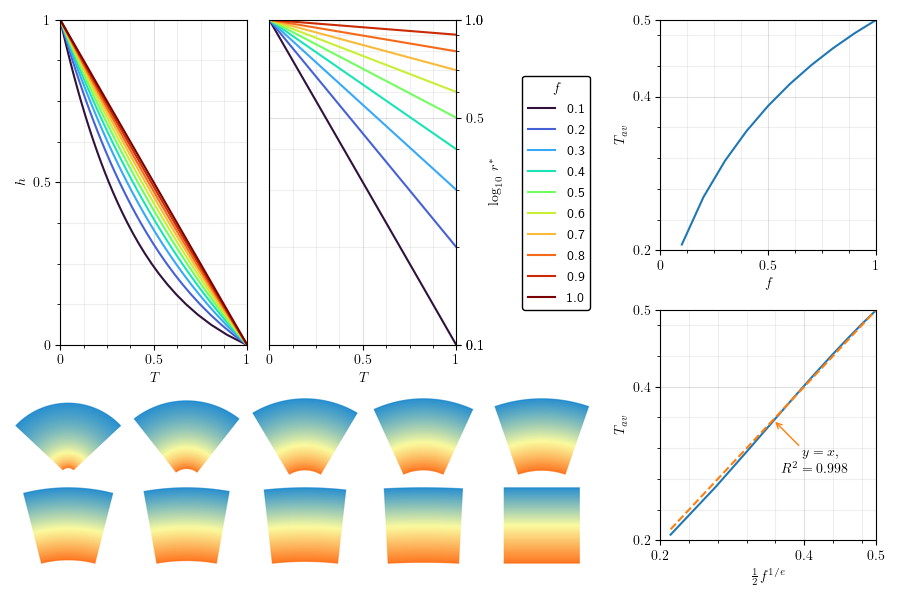

0.9981308590094721

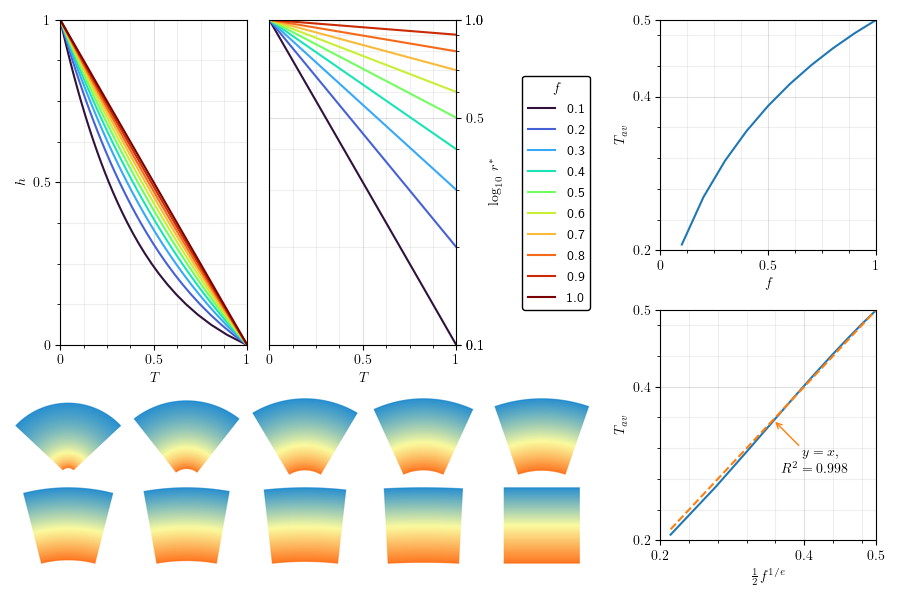

In [2]:
# fs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# geotherms = []
# condavts = []
# for f in fs:
#     system = Isovisc(alpha = 1., f = f, res = 32)
#     system.initialise()
#     temp = system.locals.temperatureField
#     diff = system.locals.diffusivityFn
#     cond = pfn.conduction.default(temp, 0, diff)
#     condavt = pfn.integral.volume(cond).data
#     left = pfn.surface.left(cond)
#     fig = QuickFig(cond, background = 'white', edgecolour = 'white')
#     geotherms.append(left.data)
#     condavts.append(condavt)
#     fig.save('cond_f' + str(f).replace('.', '-'))
# out = {
#     'fs': fs,
#     'geotherms': geotherms,
#     'avts': condavts,
#     }
# with open('cond.pkl', mode = 'wb') as file:
#     file.write(pickle.dumps(out))

impaths = sorted(os.path.relpath(path) for path in glob(osjoin(aliases.storagedir, 'cond_f*.png')))
ims = tuple(image.fromfile(path) for path in impaths)
thumbs = imop.vstack(
    imop.hstack(*ims[:5]),
    imop.hstack(*ims[5:]),
    )

with open(osjoin(aliases.storagedir, 'condf.pkl'), mode = 'rb') as file:
    conddata = pickle.loads(file.read())
condgeotherms, condavts, condfs = (conddata[key] for key in ('geotherms', 'avts', 'fs'))

canvas1 = Canvas(shape = (1, 2), size = (6, 4))

ax1 = canvas1.make_ax((0, 0))
ax2 = canvas1.make_ax((0, 1))

for f, T in zip(condfs, condgeotherms):

    f = min(0.999, f)

    h = np.linspace(0, 1, len(T))
    rinner, router = f / (1 - f), 1 / (1 - f)
    rstar = (h + rinner) / router # equiv to (h * (1 - f) + f)

    ax1.line(
        Tchan := Channel(T, label = 'T'),
        Channel(h, label = 'h'),
        c = cmap(f, condfs, style = 'turbo'),
        )

    ax2.line(
        Tchan,
        Channel(rstar, label = r"r^{*}", capped = (True, True), log = True),
        c = cmap(f, condfs, style = 'turbo'),
        )

ax2.props.edges.y.swap()

ax2.props.legend.set_handles_labels(
    (row[0] for row in ax1.collections),
    (str(f) for f in condfs),
    )
ax2.props.legend.title.text = 'f'
ax2.props.legend.title.visible = True
ax2.props.legend.mplprops['bbox_to_anchor'] = (1.75, 0.85)
# ax1.props.legend.mplprops['ncol'] = 2
ax2.props.legend.frame.colour = 'black'
ax2.props.legend.frame.visible = True

canvas2 = Canvas(size = (3, 6), shape = (2, 1))

ax1 = canvas2.make_ax(place = (0, 0))
ax1.line(
    Channel(condfs, label = 'f', lims = (0, 1.), capped = (True, True)),
    Tchan := Channel(condavts, label = 'T_{av}', lims = (0.2, 0.5), capped = (True, True)),
    )

def func(f):
    return 0.5 * f ** (1. / math.e)
predf = np.array(list(map(func, condfs)))
ax2 = canvas2.make_ax(place = (1, 0))
ax2.line(
    predfchan := Channel(predf, label = r'\frac{1}{2}f^{1/e}', lims = (0.2, 0.5), capped = (True, True)),
    Tchan,
    )
linscore = r2_score(predf, condavts)
ax2.line(
    predfchan,
    Channel(predfchan.data, lims = Tchan.lims, capped = Tchan.capped),
    linestyle = '--'
    )
trendlabel = r'y=x, \\ R^2 =' + str(round(linscore, 3))
ax2.annotate(
    predf[3],
    predf[3],
    label = trendlabel,
    points = (30, -30),
    arrowProps = dict(arrowstyle = "->", color = '#ff7f0e'),
    )

# fig = imop.hstack(imop.vstack(canvas1, thumbs), canvas2)
fig = imop.paste(
    imop.hstack(canvas1, canvas2, pad = (255, 255, 255)),
    imop.resize(thumbs, size = 0.185),
    coord = (0.01, 0.95),
    corner = 'bl',
    )

# canvas = Canvas(size = (3, 5))
# ax = canvas.make_ax()
# for condgeotherm in condgeotherms:
#     ax.line(
#         Channel(np.diff(condgeotherms[0]) / np.diff(h), label = r'\frac{dT}{dh}'),
#         Channel(h[:-1], label = 'h', lims = (0, 1), capped = (True, True)),
#         )
# canvas

glue("isocondf", fig, display = False)
glue("isocondfr2", linscore, display = False)

fig

```{glue:figure} isocondf
:figwidth: 800px
:name: "isocondf"

Summary of the scaling behaviours of isoviscous conduction for varying curvature parameter $f$. We obtain a natural scaling for $f$ versus $T_{av}$ with an $R^2$ of {glue:text}`isocondfr2:.3f`.
```

It is a requirement of a conductive steady state ($Nu=1$) that the thermal flux must be the same through every layer. In the planar case this results in a linear geotherm which, in a model with fixed and unitless boundary temperatures, results in a simple function of $T = z$ where $z$ is dimensionless depth from the top of the model. The average temperature is then trivially $T_{av}=0.5$. (For any system in pure conduction the *Nusselt* number is by definition $1$.)

In a cylindrical domain, however, the length of each successive layer goes with the radius as $2\pi r$. To sustain a given flux, then, the temperature drop across each layer must go as $\Delta T \propto r^{-1}$. Since know that, in the limit of $f$:

$$ \begin{align*}
\frac{dT}{dr} &\to -1 \quad &as \quad f \to 1 \\
&\to 0 \quad &as \quad f \to 0
\end{align*} $$

We can reconstruct the relation in terms of dimensionless radial height $r^{*}=h(1-f)+f$ as:

$$
\frac{dT}{dr^{*}} = \frac{1 - f}{r^{*}\ln{f}}
$$

The antiderivative then yields the geotherm:

$$
T(r^{*}) = \frac{\ln{r^{*}}}{\ln{f}}
$$

In the planar case, the average temperature of the system is always half the temperature drop. In the cylindrical case, however, we can observe that the average temperature sustained by the nonlinear geotherm must be a function of $f$, which will hereafter be referred to as $T_{c}$:

$$ \begin{align*}
T_{av} &= \dfrac{1}{2} \large{\root \huge{e} \of f} \\
&\equiv T_{c}
\end{align*} $$

We validate these scalings empirically {numref}`isocondf`.

This dependency of the conductive geotherm on $f$ has an immediate impact on convection and instability analysis. For one thing, it is no longer possible to identify $Nu$ as simply the dimensionless surface temperature gradient: instead, the definition of $Nu$ must scale away from surface gradient by a factor of the conductive geotherm at $h_o = r^{*}_o = 1$, which we shall for convenience term '$Nu_{c}$' - the conductive gradient of the cylindrical domain relative to that of a planar domain:

$$
Nu_{c} = \frac{1 - f}{\ln{f}}
$$

Now we may write the convective $Nu$ as:

$$
Nu = \frac{1}{Nu_{c}} \cdot \left| \frac{\partial T}{\partial r} \right| _{S}
$$

Where $|x|_S$ again represents the average value across a surface. An implication of this dependency - obvious, but worth stating - is that the upper and lower boundaries are no longer symmetrical. This invalidates many of the assumptions that made the planar case amenable to analysis. The additional space at the top of the model now allows more room for downwellings relative to basal upwellings, tending to promote instability {cite}`Jarvis1991-ir`; on the other hand, the curved geotherm and the increased surface for radiating heat would tend to permit a comparatively thicker upper boundary layer. The effect of these countervailing forcings on the fundamental scalings of $Nu$, $Ra$, $Ra_{cr}$, and the all-important relation $Nu \propto R^{\beta}$ is not obvious.

To begin to unpack the complexities of convection in the annulus, we can start with the assumption that - as in the planar case - the convective steady state will eventually result in a broad intracellular region of uniform temperature $T_{cell}$. Assuming a unit temperature drop $\Delta T = 1$, we can write:

$$ \begin{align*}
{\Delta T}_o &= T_{cell} \\
{\Delta T}_i &= 1 - T_{cell}
\end{align*} $$

Knowing that the inner and outer fluxes ${\phi_q}_i$ and ${\phi_q}_o$ must be equal at steady state, and that the outer boundary - due to its greater length - can sustain that flux with a gradient shallower by a factor of $f$, we can deduce a relation between the outer and inner thermal gradients, and thence between $T_{cell}$ and the inner and outer boundary layer thicknesses ${\Delta r}_i$ and ${\Delta r}_o$:

$$ \begin{align*}
f \frac{{\Delta T}_i}{{\Delta r}_i} &= \frac{{\Delta T}_o}{{\Delta r}_o} \\
\frac{{\Delta r}_i}{{\Delta r}_o} &= f \frac{1 - T_{cell}}{T_{cell}}
\end{align*} $$

For each of the two layers, we can prescribe a layer-specific *Rayleigh* number accordingly:

$$ \begin{align*}
Ra_o &\propto T_{cell} {{\Delta r}_o}^3 \\
Ra_i &\propto (1 - T_{cell}) {{\Delta r}_i}^3
\end{align*} $$

Having maintained non-dimensionality throughout, it is simple relate these two boundary *Rayleigh* numbers to the bulk $Ra$ value:

$$
Ra_{layer} = Ra \cdot {\Delta T}_{layer} \cdot {{\Delta r}_{layer}}^3
$$

At this point, however, we have exhausted the insight we can obtain without making further assumptions. If we provide that the inner and outer boundary thicknesses must be the same, as they are in the planar case, we can see that:

$$
T_{cell} = \frac{f}{f + 1} \quad \leftarrow {\Delta r}_i = {\Delta r}_o
$$

This, however, would imply that the inner and outer *Rayleigh* numbers are divergent. If we instead choose to conserve $Ra$, then: ({cite}`Jarvis1993-cb`)

$$
T_{cell} = \frac{1}{1 + f^{-3/4}} \quad \leftarrow Ra_i = Ra_o
$$

Both possibilities converge on $0.5$ when $f\to1$ and $0$ when $f\to0$, as we would expect.

However it is estimated, it is clear that, as $Ra$ increases and boundaries thin, more of the mantle will fall in the intracellular region and global temperatures as a whole will approach $T_{cell}$. Conversely, if $Ra$ slips below its critical value, the boundary layers will disapper and the entire domain will enter the conductive regime: $T^{av} = T_{c}$. These two temperatures therefore make up respectively the lower and upper endmembers of global temperature:

$$ \begin{align*}
T_{av} &\approx T_{c}, \quad Ra < Ra_{cr} \\
&\to T_{cell}, \quad Ra \to \infty
\end{align*} $$

It makes intuitive sense that the effect of increasing $Ra$ should be to decrease global temperatures, since that is exactly why convection is preferred wherever possible - though this intuition may not hold for all rheologies.

Of course, what we desire most of all is a cylindrical scaling for the mantle convection power law $Nu \propto R^{\beta}$. Following {cite}`Jarvis1993-cb` and mandating equality of inner and outer $Ra_{layer}$, it is possible to construct a 'geometric correction' $g(f)$ that functions as a coefficient of the *beta* scaling:

$$
g(f) = \frac{Nu_{c}}{{T_{cell}}^{4/3}} \quad \leftarrow Ra_i = Ra_o \\
Nu = g(f) \cdot R^{\frac{1}{3}}
$$

Using this scaling, Jarvis was able to obtain a *beta* exponent of $0.321 \pm 0.001$ across four values of $f$ from $(1.0 - 0.1)$ {cite}`Jarvis1993-cb`.